# Transfer Learning on Bengali Sign Language

## Setup

In [1]:
# set the python env so that we can use the project utils
import sys
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-02-01 14:27:56.444373: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738412879.174435     539 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738412879.992693     539 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-01 14:28:05.818430: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


## Load Dataset

The dataset is structured into folders. Each folder has the name of the `label` and contains all relevant `images` of this label.

Train and Test set are also found into two separate folders.

This allows us to use the `image_dataset_from_directory` method from keras to quickly load the datase.

We __normalize__ the dataset and split it into:

- train set
- validation set (15% of the train set)
- test set


In [2]:
# A quick check to find the dimentionality of the images
from PIL import Image

img = Image.open("../../sign_datasets/bengali-sign-language-dataset/RESIZED_DATASET/1/20180624_235329.jpg")

print(f'Image dimentions: {img.size}')

Image dimentions: (224, 224)


In [3]:
train_dataset_path = "../../sign_datasets/bengali-sign-language-dataset/RESIZED_DATASET"
test_dataset_path = (
    "../../sign_datasets/bengali-sign-language-dataset/RESIZED_TESTING_DATA"
)

train_dataset, val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dataset_path,
    # No resize needed, image is already 224, 244
    image_size=(224, 224),
    batch_size=64,
    validation_split=0.15,
    shuffle=True,
    seed=42,
    subset="both",
)

# The test dataset is under the test folder
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dataset_path,
    # No resize needed, image is already 224, 244
    image_size=(224, 224),
    batch_size=64,
    shuffle=True,
)


def normalize_image(image, label):
    precomputed_mean = [0.6287722587585449, 0.6092960834503174, 0.5825445055961609]
    precomputed_std = [0.6499956250190735, 0.6389758586883545, 0.6195625066757202]

    # Normalize the image
    image = (image / 255.0 - precomputed_mean) / precomputed_std
    return image, label


train_dataset = train_dataset.map(normalize_image)
val_dataset = val_dataset.map(normalize_image)
test_dataset = test_dataset.map(normalize_image)

print(
    f"Train size: {train_dataset.cardinality().numpy()}. Validation size will be: {val_dataset.cardinality().numpy()}"
)

# Set performance settings
# Prefetch one batch at a time
buffer_size = 1
train_dataset = train_dataset.prefetch(buffer_size=buffer_size)
val_dataset = val_dataset.prefetch(buffer_size=buffer_size)
test_dataset = test_dataset.prefetch(buffer_size=buffer_size)


Found 11061 files belonging to 38 classes.
Using 9402 files for training.
Using 1659 files for validation.


I0000 00:00:1738412923.395808     539 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2859 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


Found 1520 files belonging to 38 classes.
Train size: 147. Validation size will be: 26


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9402514..0.24970913].


(64, 224, 224, 3)


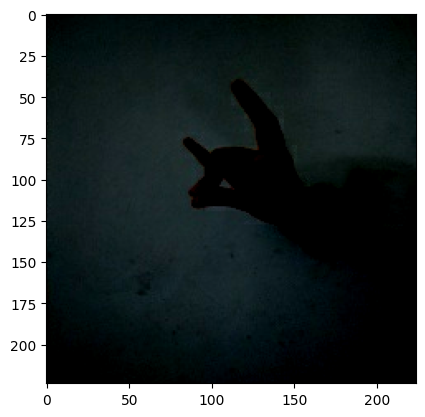

In [4]:
# Print a random image to make sure it's properly shown
images, labels = next(iter(train_dataset))

print(images.shape)

plt.imshow(images[0, :, :, :])
plt.show()

## Helper Methods

The following methods aim to make the code easier

In [5]:
from sklearn.metrics import confusion_matrix


def get_class_count(dataset):
    """Find out how many elements bellong to each class
    This method is used in plot_class_distribution to plot
    the distribution of the data
    
    Return:
        class_counts: A dictionary with the class name as a key
        and the total items as a value
    """
    class_counts = {}
    for images, labels in tqdm(dataset):
        for label in labels:
            # Here the label is a tensor with 1 element
            # We have to convert it to numpy
            label = label.numpy()
            # Count it
            class_counts[label] = class_counts.get(label, 0) + 1
    # Return the counts
    return class_counts

def plot_class_distribution(dataset, title: str):
    """Get how many elements belong to each class and plot them
    
    This method can help us see if there is an inbalance in the data
    """
    # Get the class counts
    class_counts = get_class_count(dataset)

    # greate an index for the dataframe
    index = list(range(len(class_counts)))
    # Create a dataframe
    df = pd.DataFrame(class_counts, index=index)
    
    # Set the figure size
    plt.figure(figsize=(12, 6))
    # Add the data
    ax = sns.barplot(df)
    # Set the title
    ax.set_title(title)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    # Adjust layout to make room for rotated labels
    plt.tight_layout()
    plt.show()

def plot_history(history):
    """Plot the history returned by the training
    """

    # Convert history to a DataFrame
    history_df = pd.DataFrame(history.history)

    # Create a single figure with two subplots
    fig, ax1 = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plotting training and validation loss
    sns.lineplot(data=history_df[['loss', 'val_loss']], ax=ax1[0])
    ax1[0].set_title('Model Loss')
    ax1[0].set_xlabel('Epochs')
    ax1[0].set_ylabel('Loss')
    ax1[0].legend(['Train', 'Validation'])
    
    # Plotting training and validation accuracy
    sns.lineplot(data=history_df[['accuracy', 'val_accuracy']], ax=ax1[1])
    ax1[1].set_title('Model Accuracy')
    ax1[1].set_xlabel('Epochs')
    ax1[1].set_ylabel('Accuracy')
    ax1[1].legend(['Train', 'Validation'])
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

## Visualizations

Bellow we can see some visualizations for this dataset

100%|██████████| 147/147 [00:15<00:00,  9.55it/s]


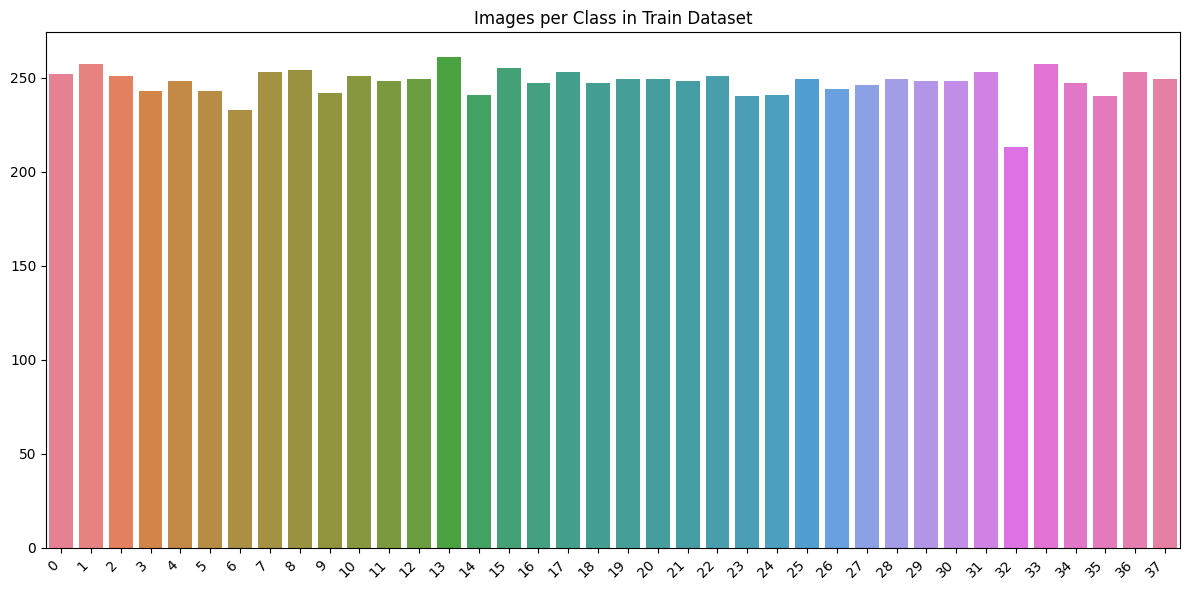

In [11]:
plot_class_distribution(train_dataset, "Images per Class in Train Dataset")

100%|██████████| 26/26 [00:05<00:00,  5.04it/s]


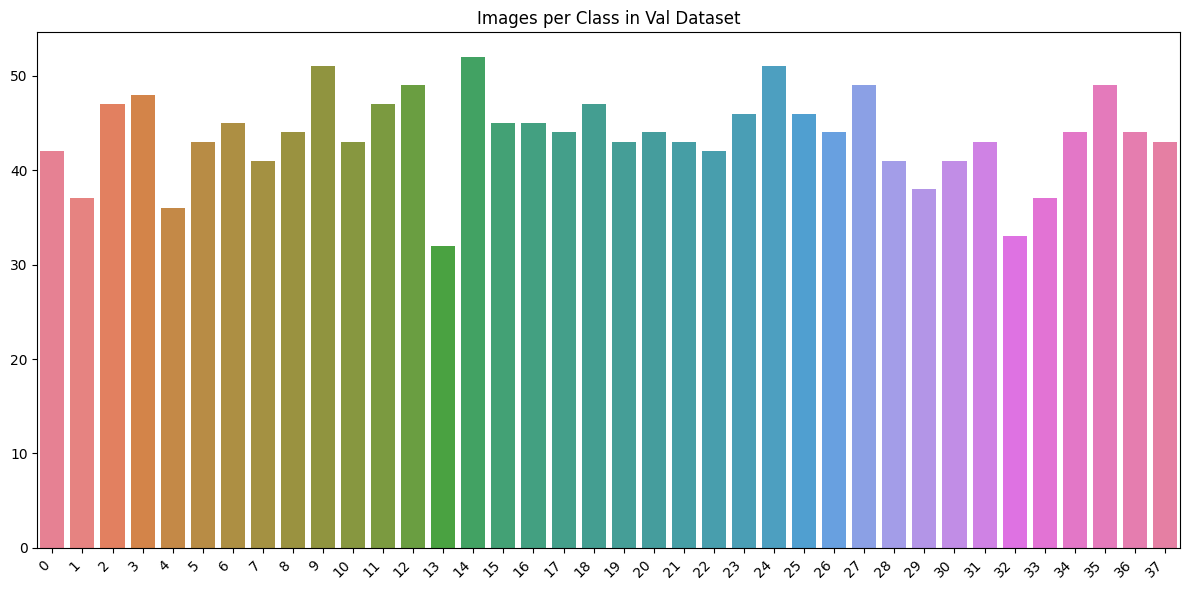

In [12]:
plot_class_distribution(val_dataset, "Images per Class in Val Dataset")

100%|██████████| 24/24 [00:01<00:00, 12.48it/s]


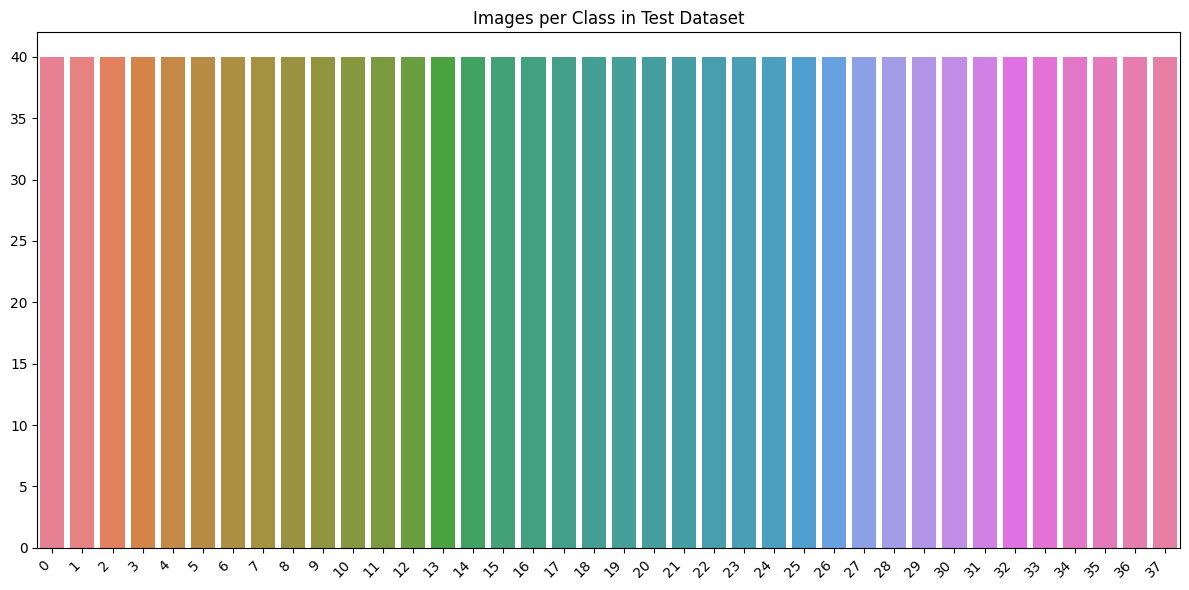

In [13]:
plot_class_distribution(test_dataset, "Images per Class in Test Dataset")

## Extract Class Names

In [6]:
def get_class_names(test_dataset, verbose: bool = False):
    class_names = set()

    for _, labels in tqdm(test_dataset, desc="Gathering Labels"):
        for label in labels:
            class_names.add(int(label))

    if verbose:
        print(f"Unique Dataset Labels: {class_names}")

    return class_names

In [7]:
class_names = get_class_names(test_dataset=test_dataset, verbose=True)

Gathering Labels: 100%|██████████| 24/24 [00:02<00:00,  8.26it/s]

Unique Dataset Labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37}


## MobileNet Transfer Learning

Let's try to finetune `MobileNetV2` for our task.

MobileNetV2 is trained on the `imagenet` dataset.

Due to the fact that it works with some specific image sizes, we have to reshape our images from (400, 400) to (224, 244)

We will try __different hidden sizes__ with __3 epochs__, using a __dropout__ of 0.3

---------------------------
---------------------------
HIDDEN SIZE: 128
---------------------------


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,366 (9.26 MB)

 Trainable params: 169,126 (660.65 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

None
Epoch 1/2


I0000 00:00:1738411464.486176    3495 service.cc:148] XLA service 0x7f1244003b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738411464.508631    3495 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2025-02-01 14:04:24.995201: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738411466.179938    3495 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-01 14:04:31.853192: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k5=1,k6=0,k7=1,k10=7} for conv (f32[64,32,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,32,112,112]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=32, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation

  1/147 ━━━━━━━━━━━━━━━━━━━━ 1:00:12 25s/step - accuracy: 0.0000e+00 - loss: 4.2550

I0000 00:00:1738411482.825628    3495 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


147/147 ━━━━━━━━━━━━━━━━━━━━ 74s 336ms/step - accuracy: 0.2765 - loss: 2.7884 - val_accuracy: 0.6540 - val_loss: 1.3439
Epoch 2/2
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 153ms/step - accuracy: 0.6612 - loss: 1.2435 - val_accuracy: 0.7577 - val_loss: 0.8978
New best model found


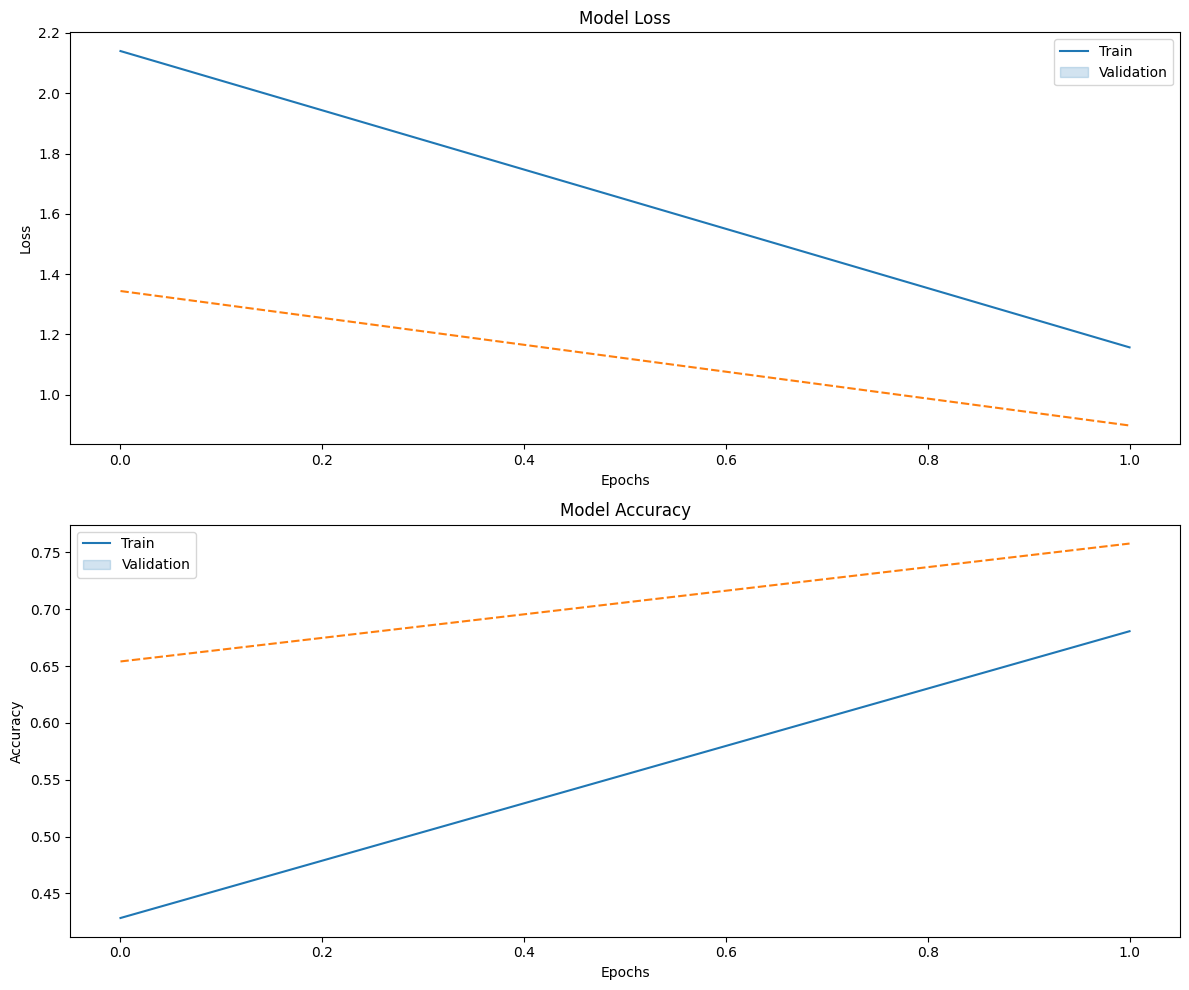

---------------------------
---------------------------
HIDDEN SIZE: 256
---------------------------


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,596,710 (9.91 MB)

 Trainable params: 338,214 (1.29 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

None
Epoch 1/2
147/147 ━━━━━━━━━━━━━━━━━━━━ 42s 215ms/step - accuracy: 0.3420 - loss: 2.4921 - val_accuracy: 0.7101 - val_loss: 1.0851
Epoch 2/2
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 155ms/step - accuracy: 0.7277 - loss: 0.9240 - val_accuracy: 0.7691 - val_loss: 0.8056
New best model found


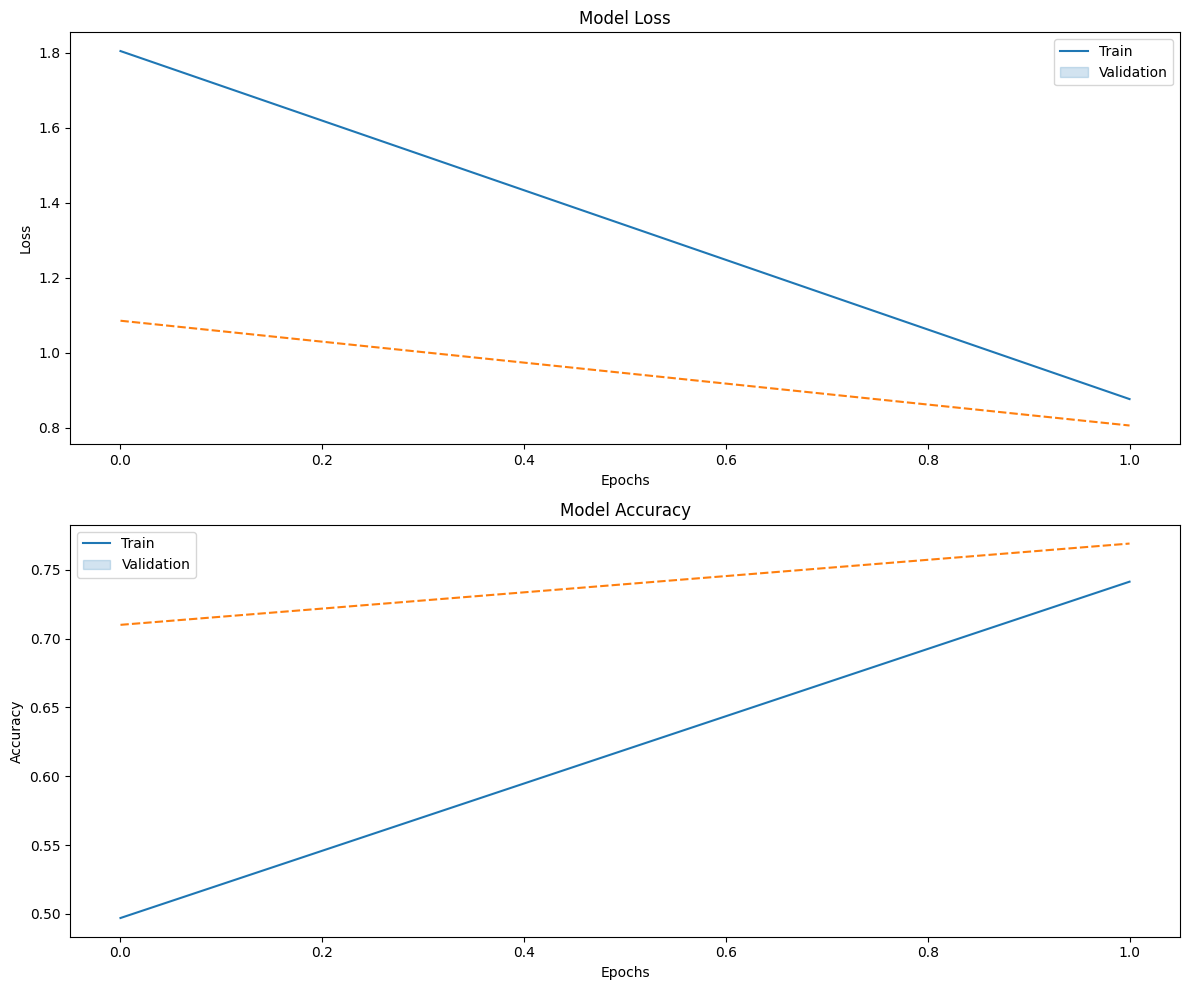

---------------------------
---------------------------
HIDDEN SIZE: 512
---------------------------


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 38)             │        19,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,935,398 (11.20 MB)

 Trainable params: 676,390 (2.58 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

None
Epoch 1/2
147/147 ━━━━━━━━━━━━━━━━━━━━ 43s 217ms/step - accuracy: 0.4161 - loss: 2.1608 - val_accuracy: 0.7330 - val_loss: 0.9080
Epoch 2/2
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 157ms/step - accuracy: 0.7908 - loss: 0.7084 - val_accuracy: 0.7770 - val_loss: 0.7105
New best model found


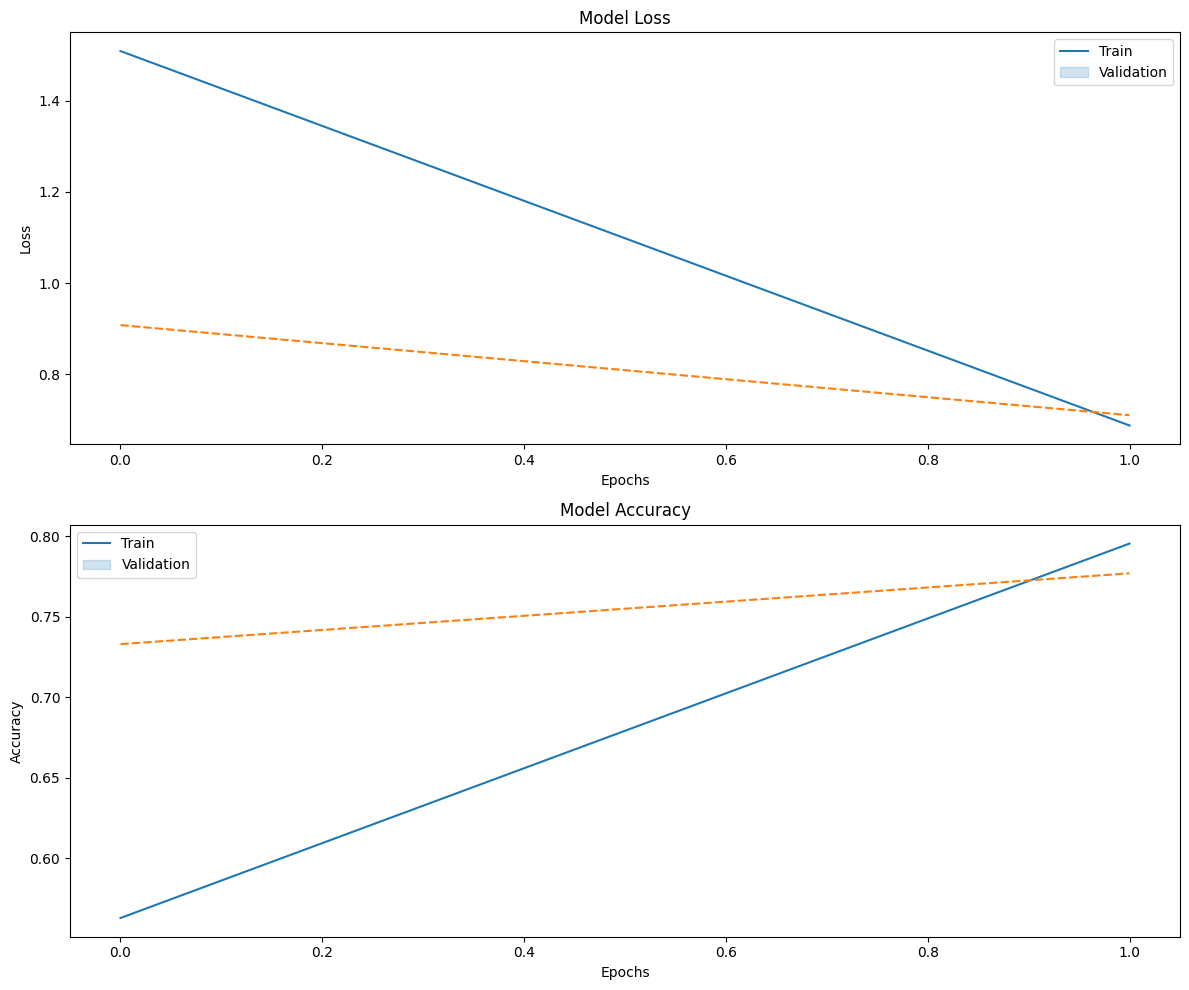

24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 599ms/step - accuracy: 0.7927 - loss: 0.6741
Test Loss: 0.7009738087654114
Test Accuracy: 0.7835526466369629


In [17]:
hidden_sizes = [128, 256, 512]
best_model = None
best_acc = -1
for hidden_size in hidden_sizes:

    print('---------------------------')
    print('---------------------------')
    print(f'HIDDEN SIZE: {hidden_size}')
    print('---------------------------')

    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3), include_top=False, weights="imagenet"
    )
    # we dont want to train the base model
    base_model.trainable = False

    # TODO add mobilenet specific preprocessing
    
    # Add custom layers on top of the base model
    model = tf.keras.Sequential(
        [
            base_model,
            # This is added to reduce the number of parameters
            tf.keras.layers.GlobalAveragePooling2D(),
            # Add our custom hidden size
            tf.keras.layers.Dense(hidden_size, activation=None),
            # Use a batch normalization layer
            tf.keras.layers.BatchNormalization(),
            # Then the relu
            tf.keras.layers.Activation("relu"),
            # Dropout of 0.3
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(len(class_names), activation="softmax"),
        ]
    )
    
    print(model.summary())
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=2)

    # make sure to keep the best model
    if best_model is None or history.history['val_accuracy'][-1] > best_acc:
        print('New best model found')
        best_model = model
        best_acc = history.history['val_accuracy'][-1]

    # plot two graphs, one for the train / val loss and one for the train / val accuracy
    plot_history(history)


# Finally inference with the best model
results = best_model.evaluate(test_dataset)

print(f'Test Loss: {results[0]}')
print(f'Test Accuracy: {results[1]}')

## Confusion Matrix

  0%|          | 0/24 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


  4%|▍         | 1/24 [00:00<00:20,  1.13it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


  8%|▊         | 2/24 [00:01<00:14,  1.54it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 12%|█▎        | 3/24 [00:01<00:10,  2.03it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 17%|█▋        | 4/24 [00:01<00:08,  2.41it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 21%|██        | 5/24 [00:02<00:07,  2.55it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 25%|██▌       | 6/24 [00:02<00:08,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 29%|██▉       | 7/24 [00:03<00:07,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 33%|███▎      | 8/24 [00:03<00:06,  2.44it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 38%|███▊      | 9/24 [00:03<00:05,  2.58it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 42%|████▏     | 10/24 [00:04<00:05,  2.75it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 46%|████▌     | 11/24 [00:04<00:04,  2.78it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 50%|█████     | 12/24 [00:04<00:04,  2.86it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 54%|█████▍    | 13/24 [00:05<00:03,  2.89it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 58%|█████▊    | 14/24 [00:05<00:03,  2.79it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 62%|██████▎   | 15/24 [00:06<00:03,  2.88it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 67%|██████▋   | 16/24 [00:06<00:02,  2.97it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 71%|███████   | 17/24 [00:06<00:02,  3.18it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 75%|███████▌  | 18/24 [00:06<00:01,  3.50it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 79%|███████▉  | 19/24 [00:07<00:01,  3.74it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 83%|████████▎ | 20/24 [00:07<00:00,  4.06it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 88%|████████▊ | 21/24 [00:07<00:00,  3.99it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 92%|█████████▏| 22/24 [00:07<00:00,  3.39it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 96%|█████████▌| 23/24 [00:08<00:00,  3.42it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step 


100%|██████████| 24/24 [00:08<00:00,  2.84it/s]


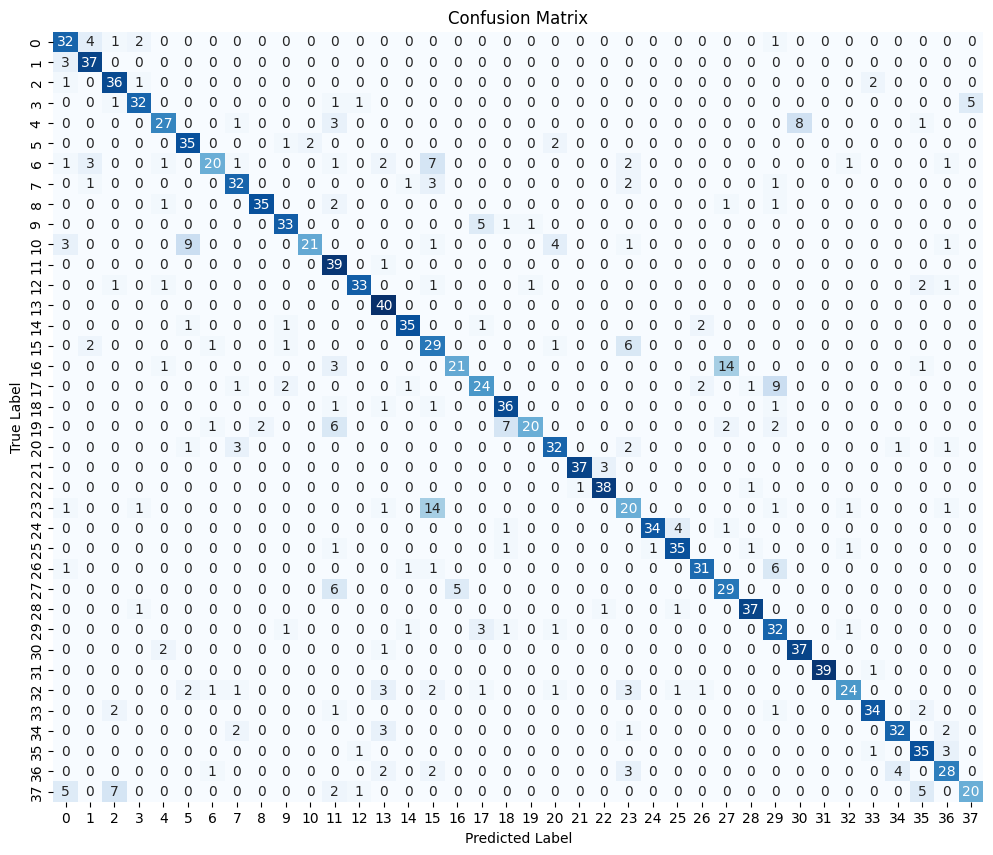

In [19]:
y_pred = []
y_true = []
for x_batch, y_batch in tqdm(test_dataset):
    y_pred_prob = best_model.predict(x_batch)

    y_pred.extend(np.argmax(y_pred_prob, axis=1))
    y_true.extend(y_batch.numpy())

plot_confusion_matrix(y_true, y_pred, classes=class_names)

## ConvNeXtBase Transfer Learning

Let's try to finetune `ConvNeXtBase` for our task.

`ConvNeXtBase` is trained on the `imagenet` dataset

---------------------------
---------------------------
HIDDEN SIZE: 128
---------------------------


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)      │ (None, 7, 7, 1024)     │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,703,078 (334.56 MB)

 Trainable params: 136,358 (532.65 KB)

 Non-trainable params: 87,566,720 (334.04 MB)

None
Epoch 1/2


I0000 00:00:1738412983.929959     991 service.cc:148] XLA service 0x7f8668011e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738412983.976297     991 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2025-02-01 14:29:45.972089: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738412989.347943     991 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1738413005.220448     991 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


147/147 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step - accuracy: 0.2315 - loss: 3.0298 - val_accuracy: 0.3816 - val_loss: 2.5459
Epoch 2/2
147/147 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 0.6384 - loss: 1.4155 - val_accuracy: 0.5407 - val_loss: 1.7683
New best model found


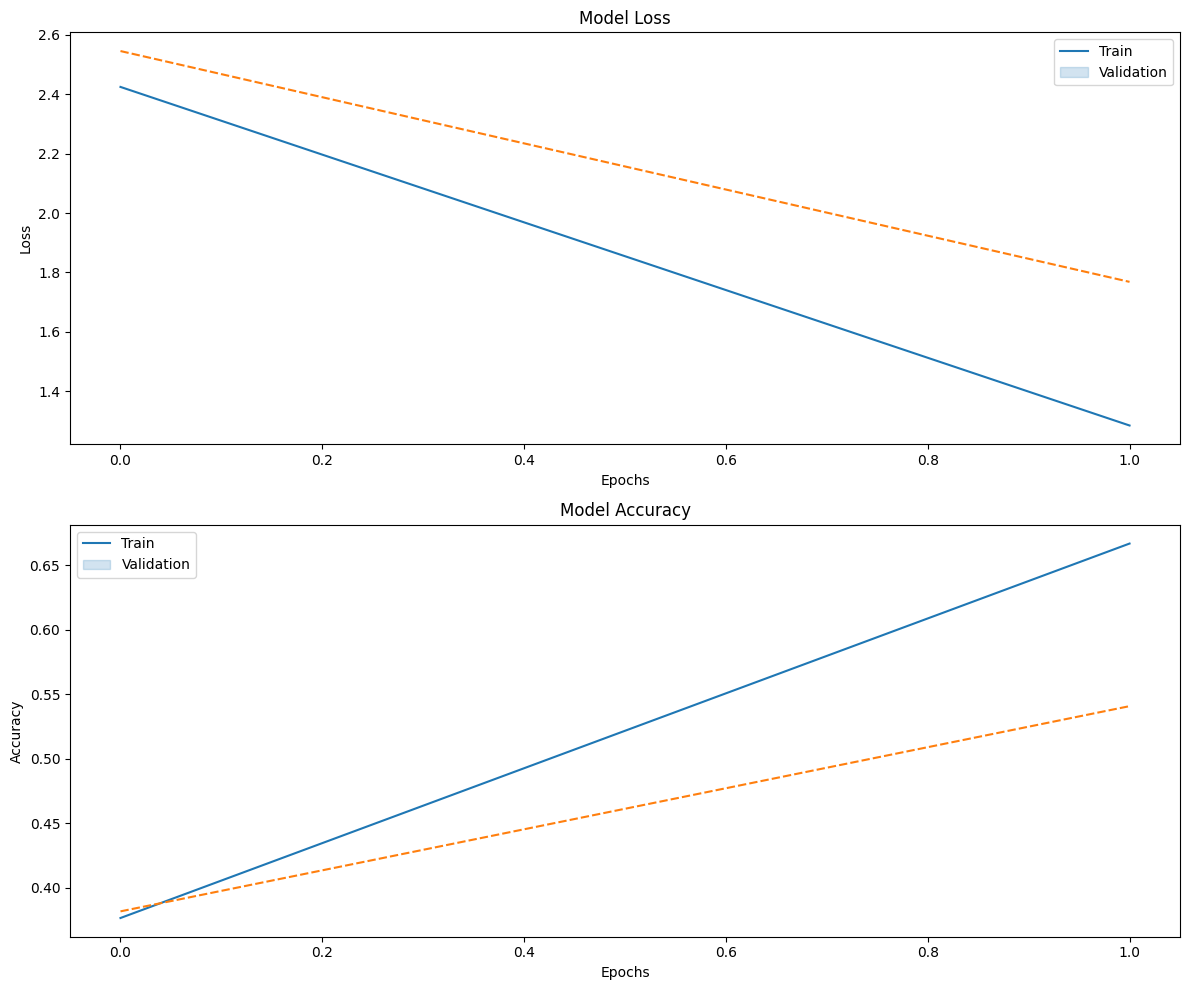

---------------------------
---------------------------
HIDDEN SIZE: 256
---------------------------


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)      │ (None, 7, 7, 1024)     │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,839,654 (335.08 MB)

 Trainable params: 272,678 (1.04 MB)

 Non-trainable params: 87,566,976 (334.04 MB)

None
Epoch 1/2
147/147 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.2886 - loss: 2.7569 - val_accuracy: 0.4129 - val_loss: 2.2727
Epoch 2/2
147/147 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 0.6989 - loss: 1.1205 - val_accuracy: 0.6371 - val_loss: 1.3793
New best model found


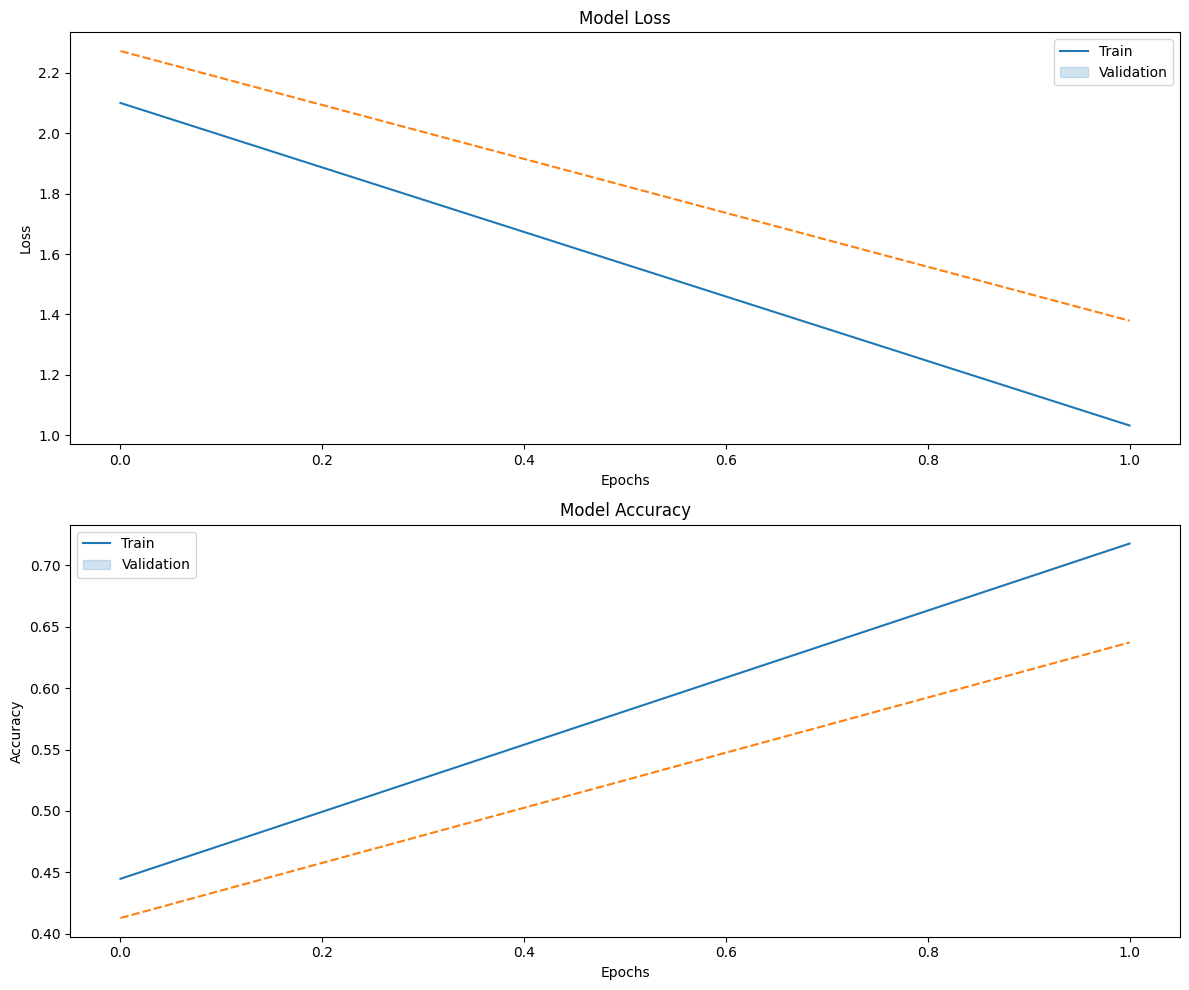

---------------------------
---------------------------
HIDDEN SIZE: 512
---------------------------


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)      │ (None, 7, 7, 1024)     │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 38)             │        19,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,112,806 (336.12 MB)

 Trainable params: 545,318 (2.08 MB)

 Non-trainable params: 87,567,488 (334.04 MB)

None
Epoch 1/2
147/147 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.3355 - loss: 2.5902 - val_accuracy: 0.4497 - val_loss: 2.1046
Epoch 2/2
147/147 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 0.7331 - loss: 0.9529 - val_accuracy: 0.5883 - val_loss: 1.5107


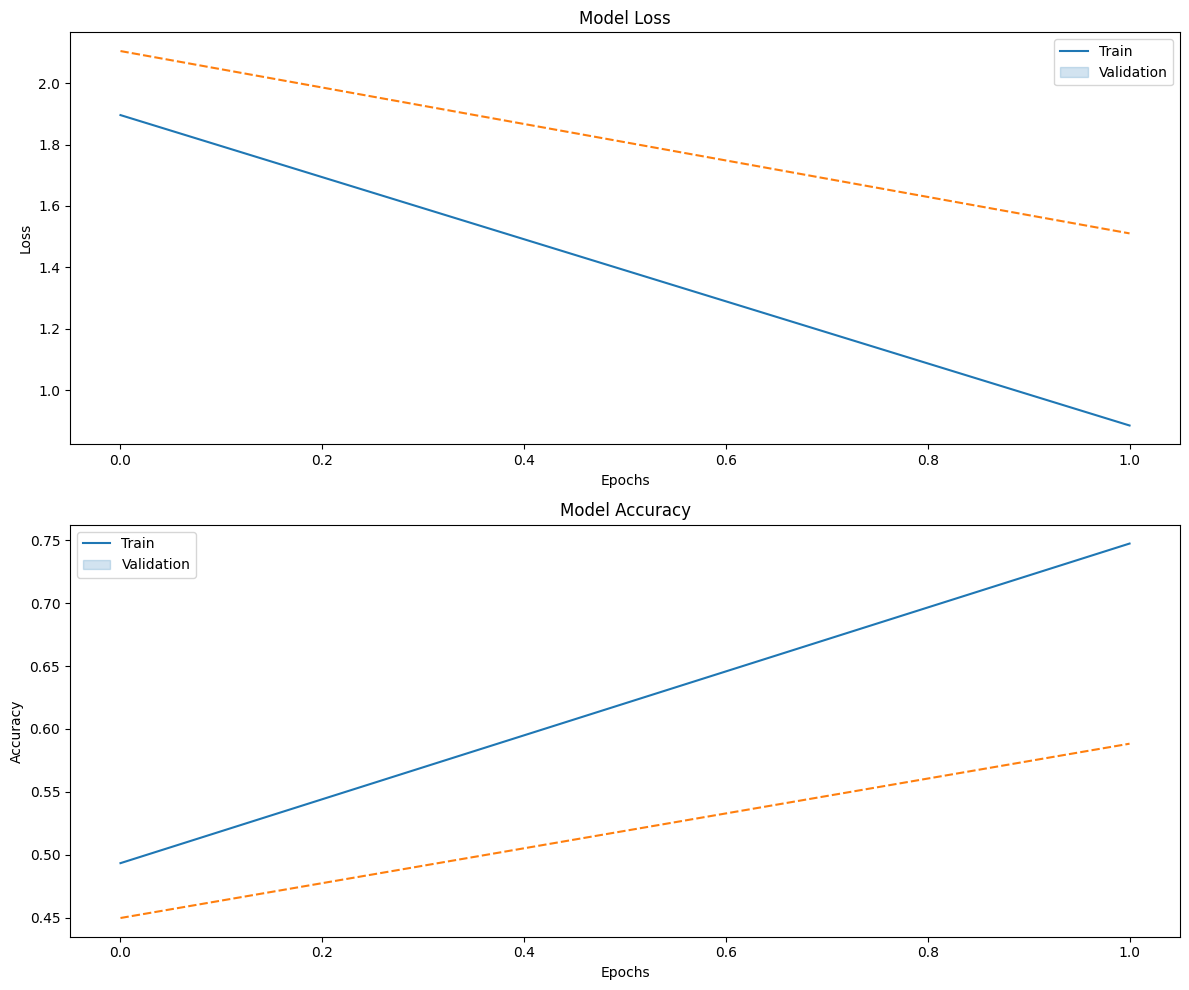

24/24 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.5838 - loss: 1.5615
Test Loss: 1.5718998908996582
Test Accuracy: 0.5736842155456543


In [8]:
hidden_sizes = [128, 256, 512]
best_model = None
best_acc = -1
for hidden_size in hidden_sizes:

    print('---------------------------')
    print('---------------------------')
    print(f'HIDDEN SIZE: {hidden_size}')
    print('---------------------------')

    base_model = tf.keras.applications.ConvNeXtBase(
        input_shape=(224, 224, 3), include_top=False, weights="imagenet"
    )
    # we dont want to train the base model
    base_model.trainable = False

    # Add custom layers on top of the base model
    model = tf.keras.Sequential(
        [
            base_model,
            # This is added to reduce the number of parameters
            tf.keras.layers.GlobalAveragePooling2D(),
            # Add our custom hidden size
            tf.keras.layers.Dense(hidden_size, activation=None),
            # Use a batch normalization layer
            tf.keras.layers.BatchNormalization(),
            # Then the relu
            tf.keras.layers.Activation("relu"),
            # Dropout of 0.3
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(len(class_names), activation="softmax"),
        ]
    )
    
    print(model.summary())
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=2)

    # make sure to keep the best model
    if best_model is None or history.history['val_accuracy'][-1] > best_acc:
        print('New best model found')
        best_model = model
        best_acc = history.history['val_accuracy'][-1]

    # plot two graphs, one for the train / val loss and one for the train / val accuracy
    plot_history(history)

# Finally inference with the best model
results = best_model.evaluate(test_dataset)

print(f'Test Loss: {results[0]}')
print(f'Test Accuracy: {results[1]}')

## Confusion Matrix

  0%|          | 0/24 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 814ms/step


  4%|▍         | 1/24 [00:14<05:33, 14.52s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 811ms/step


  8%|▊         | 2/24 [00:16<02:33,  6.98s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 824ms/step


 12%|█▎        | 3/24 [00:17<01:36,  4.57s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 819ms/step


 17%|█▋        | 4/24 [00:19<01:08,  3.44s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 822ms/step


 21%|██        | 5/24 [00:21<00:53,  2.82s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 822ms/step


 25%|██▌       | 6/24 [00:23<00:44,  2.45s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 815ms/step


 29%|██▉       | 7/24 [00:24<00:37,  2.21s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 812ms/step


 33%|███▎      | 8/24 [00:26<00:32,  2.05s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 821ms/step


 38%|███▊      | 9/24 [00:28<00:29,  1.94s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 823ms/step


 42%|████▏     | 10/24 [00:29<00:26,  1.86s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 815ms/step


 46%|████▌     | 11/24 [00:31<00:23,  1.81s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 826ms/step


 50%|█████     | 12/24 [00:33<00:21,  1.78s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 815ms/step


 54%|█████▍    | 13/24 [00:35<00:19,  1.76s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 814ms/step


 58%|█████▊    | 14/24 [00:36<00:17,  1.74s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 815ms/step


 62%|██████▎   | 15/24 [00:38<00:15,  1.73s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 813ms/step


 67%|██████▋   | 16/24 [00:40<00:13,  1.71s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 817ms/step


 71%|███████   | 17/24 [00:41<00:11,  1.70s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 824ms/step


 75%|███████▌  | 18/24 [00:43<00:10,  1.70s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 840ms/step


 79%|███████▉  | 19/24 [00:45<00:08,  1.71s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 812ms/step


 83%|████████▎ | 20/24 [00:46<00:06,  1.70s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 819ms/step


 88%|████████▊ | 21/24 [00:48<00:05,  1.70s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 811ms/step


 92%|█████████▏| 22/24 [00:50<00:03,  1.70s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 816ms/step


 96%|█████████▌| 23/24 [00:51<00:01,  1.69s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 10s/step


100%|██████████| 24/24 [01:02<00:00,  2.61s/it]


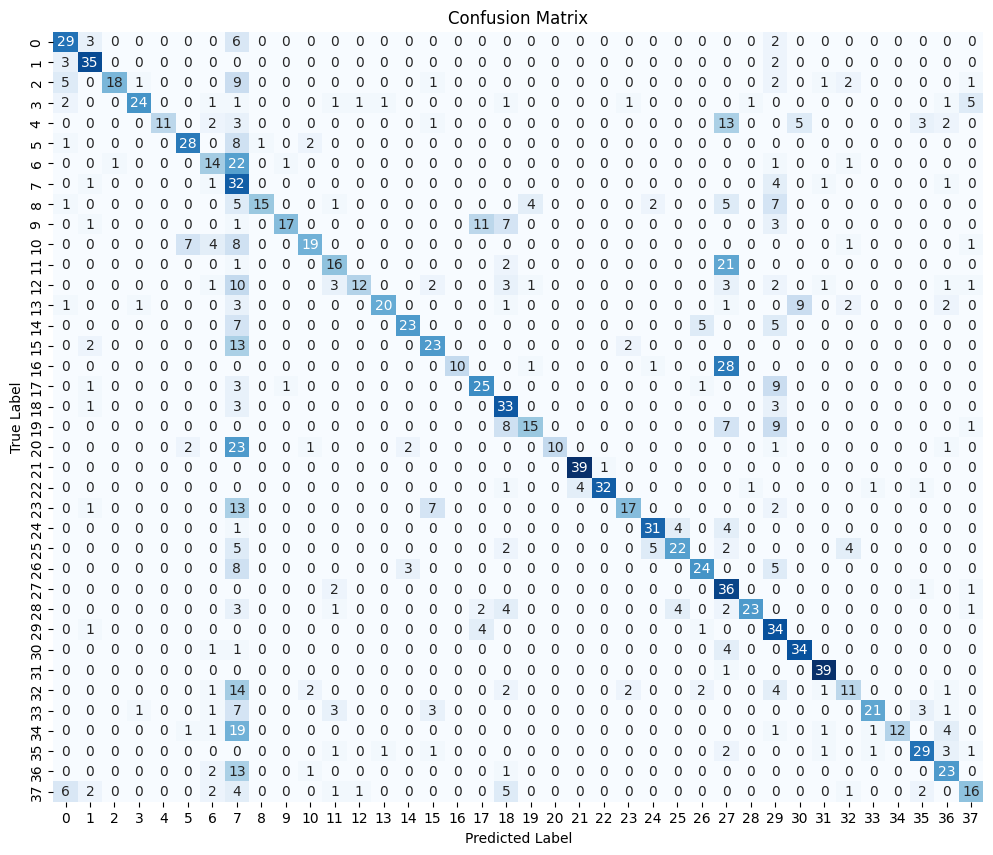

In [9]:
y_pred = []
y_true = []
for x_batch, y_batch in tqdm(test_dataset):
    y_pred_prob = best_model.predict(x_batch)

    y_pred.extend(np.argmax(y_pred_prob, axis=1))
    y_true.extend(y_batch.numpy())

plot_confusion_matrix(y_true, y_pred, classes=class_names)